https://github.com/vcasadei/Redes-Neurais-CESAR-School/tree/2024.02
Linnk github professor para acessar os notebooks


# Regressão Linear

In [1]:
!pip install torch torchvision torchaudio

In [2]:
# http://pytorch.org/
from os.path import exists
import torch

## Objetivos

Os objetivos deste notebook são:

* introduzir os conceitos básicos iniciais de redes neurais através da
* otimização de um ajuste de pontos por uma reta (linear) utilizando a
* técnica de cálculo numérico do gradiente descendente.

Este notebook contém uma demonstração iterativa do laço de otimização, com visualização:
* reta de ajuste sendo otimizada
* valores dos parâmetros sendo ajustados
* função de perda sendo minimizada

## Problema de Regressão Linear

O problema de ajuste de uma reta a um conjunto de pontos para verificar se existe uma previsão linear é um problema muito antigo, muito estudado e muito presente nos dias de hoje.

Quando o ajuste é abordado como um problema de **otimização numérica**, ele é a base de boa parte dos **conceitos sobre redes neurais** e iremos explorá-lo aqui como uma forma de introdução às redes neurais. O modelo de regressão linear que iremos utilizar pode
ser visto como uma rede neural de apenas uma camada e função de ativação linear.

## Conjunto de dados: Flores Íris

Iremos utilizar duas propriedades do conjunto de dados das flores Íris [Wikipedia-Iris_flower_data_set](https://en.wikipedia.org/wiki/Iris_flower_data_set):

* o comprimento das sépalas e
* o comprimento da pétalas.

A ideia será prever o comprimento da pétala, conhecendo-se o comprimento da sépala. Estaremos usando apenas uma propriedade, ou característica ou *feature* do objeto para que seja fácil visualizar o espaço de busca de parâmetros.

Vamos utilizar as 50 amostras da variedade versicolor.

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/iris_petals_sepals.png)

## Dados: leitura e visualização


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython import display

import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
import time

In [4]:
iris = load_iris()
data = iris.data[iris.target==1,::2]  # comprimento das sépalas e pétalas, indices 0 e 2

x_in = data[:,0:1]
y_in = data[:,1:2]
iris_pd = pd.DataFrame(x_in, columns=['x_in'])
iris_pd['y_in'] = y_in
iris_pd.head()

,x_in,y_in
0,7.0,4.7
1,6.4,4.5
2,6.9,4.9
3,5.5,4.0
4,6.5,4.6


In [5]:
iris


{'data': array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
  

## Visualização dos dados `x_in` e `y_in` e normalizados

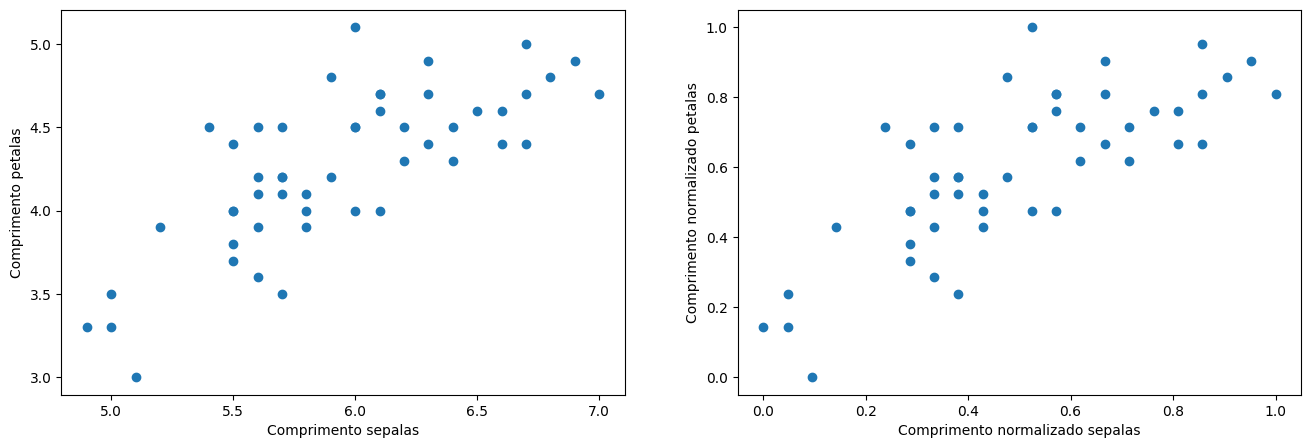

In [6]:
x = x_in - x_in.min()
x /= x.max()    # normalização min e max
y = y_in - y_in.min()
y /= y.max()

fig = plt.figure(figsize=(16,5))
ax_in = fig.add_subplot(1,2,1)
ax_in.scatter(x_in, y_in)
ax_in.set_xlabel('Comprimento sepalas')
ax_in.set_ylabel('Comprimento petalas')
ax_n = fig.add_subplot(1,2,2)
ax_n.scatter(x, y)
ax_n.set_xlabel('Comprimento normalizado sepalas')
ax_n.set_ylabel('Comprimento normalizado petalas');

## Reta de ajuste

A equação da reta no plano necessita de dois parâmetros, aqui denominados $w_0$ (*bias*) e inclinação $w_1$. Veja figura:

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/linhareta.png)

A reta de ajuste será dada por:

$$ \hat{y} = w_0 + w_1 x $$

onde
* $w_1$ é o coeficiente angular da reta e
* $w_0$ é a interseção do eixo vertical quando x é igual a zero, também denominado de *bias*.
* $x$ é a variável de entrada (comprimento das sépalas) e
* $\hat{y}$ é a predição (comprimento estimado das pétalas).

## Representação gráfica da equação linear via neurônio

$ \hat{y} = 1 w_0 + x_0 w_1 $

Temos:
- 1 atributo de entrada: $x_0$
- 2 parâmetros para serem ajustados (treinados) $w_0$ e $w_1$
- 1 classe de saída $\hat{y}$
![alt text]![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoLinearNeuronio.png)
$$ \hat{y} = w_0 + w_1 x $$
$$ \mathbf{\hat{y}} = \mathbf{w} \mathbf{x} $$

### Função Custo ou de Perda (MSE - Mean Square Error)

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/Loss_MSE.png)



A função de custo depende do conjunto de treinamento ($y_i$) e dos valores de predição ($\hat{y_i}$):

$$ J(\hat{y_i},y_i) = \frac{1}{M} \sum_{i=0}^{M-1} (\hat{y_i} - y_i)^2 $$ .


## Laço de minimização via gradiente descendente

O código da próxima célula é a parte principal deste notebook. É aqui que a minimização é feita. É aqui que dizemos que estamos fazendo o *fit*, ou o treinamento do sistema para encontrar o parâmetro $\mathbf{W}$ que minimiza a função de perda $J$. Acompanhamos a convergência da minimização pelo valor da perda a cada iteração, plotando o vetor `J_history`.

O esquema da otimização é representado pelo diagrama a seguir:

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoLinear_Otimizacao.png)

e é implementado pela próxima célula de código:

## Funções: Custo, Gradiente Descendente

In [7]:
def compute_cost(X_b, y, wT):
    '''
    Compute cost for linear regression
    (X,y): amostras rotuladas X(n_samples,2) e y(n_samples,)
    wT: vetor coluna de parâmetros (já transposto)
       aceita tanto shape (2,1) Para um caso como (2,n_history) para n_history casos
    '''
    e = X_b.dot(wT) - y
    J = (e * e).mean(axis=0)
    return J

In [8]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable

def train_net(X, y, lr=0.5, n_epochs=50, batch_size=10, shuffle=True, rnd_seed=445):
    torch.manual_seed(rnd_seed)
    # Data Loader
    dloader = DataLoader(TensorDataset(torch.from_numpy(X.astype(np.float32)),
                                       torch.from_numpy(y.astype(np.float32))),
                         batch_size=batch_size, shuffle=shuffle)
    # Modelo da rede
    model = torch.nn.Linear(1, 1)
    model.load_state_dict(dict(weight=torch.zeros(1,1), bias=torch.zeros(1)))
    # Função de perda
    criterion = torch.nn.MSELoss()
    # Otimizador do gradiente descendente
    optimizer = torch.optim.SGD(params=model.parameters(), lr=lr)

    losses = []
    w_history = np.zeros((n_epochs + 1, 2), np.float32)
    model.train(True)
    # Laço de treinamento - epocas
    for epoch in range(n_epochs):
        cost = 0
        samp = 0
        for x, y in dloader:
            optimizer.zero_grad()
            pred = model(Variable(x))
            loss = criterion(pred, Variable(y))
            loss.backward()
            optimizer.step()

            cost += loss.data
            samp += 1

        losses.append(cost / samp)
        w, b = [ww.data for ww in model.parameters()]
        w_history[epoch + 1, 0] = b[0]
        w_history[epoch + 1, 1] = w[0, 0]

    return losses, w_history


## Plot

In [9]:
def show_plots(x, y, lr=0.5, n_epochs=50, n_batch=50, shuffle=True, sleep=0.3):
    n_samples = y.shape[0]

    # minimização via gradiente descendente
    # -------------------------------------
    J_history, w_history = train_net(x, y, lr=lr, n_epochs=n_epochs, batch_size=n_batch, shuffle=shuffle)

    # valor ótimo, solução analítica
    # ------------------------------
    X_bias = np.hstack([np.ones((n_samples, 1)), x])
    w_opt = (np.linalg.inv((X_bias.T).dot(X_bias)).dot(X_bias.T)).dot(y)
    X_all = np.linspace(x.min(), x.max(), 100).reshape(100, 1)
    X_all_bias = np.hstack([np.ones((100, 1)), X_all])
    result_opt = X_all_bias.dot(w_opt)    # Predição do valor ótimo

    # matriz bidimensional de parâmetros
    # ----------------------------------
    wmin = w_history.min(axis=0)
    wmax = w_history.max(axis=0)
    D = wmax - wmin
    wmin -= D
    wmax += D
    ww0, ww1 = np.meshgrid(np.linspace(wmin[0], wmax[0], 100), np.linspace(wmin[1], wmax[1], 100))
    w_grid = np.c_[ww0.ravel(), ww1.ravel()]
    J_grid = compute_cost(X_bias, y, w_grid.T)
    J_grid = J_grid.reshape(ww0.shape)

    # Gráficos:
    # --------
    fig = plt.figure(figsize=(18, 6))
    ax_line = fig.add_subplot(1, 3, 1)    # linha reta
    ax_grid = fig.add_subplot(1, 3, 2)
    ax_loss = fig.add_subplot(1, 3, 3)    # função perda

    ax_loss.plot(J_history)
    ax_loss.set_title('Perda', fontsize=15)
    ax_loss.set_xlabel('epochs', fontsize=10)
    ax_loss.set_ylabel('MSE', fontsize=10)

    ax_line.scatter(x, y, marker='o', c='b')    # plotagem dos pontos azuis no Iris dataset
    ax_line.set_title('Iris dataset', fontsize=15)
    ax_line.set_xlabel('x', fontsize=10)
    ax_line.set_ylabel('y', fontsize=10)
    ax_line.plot(X_all, result_opt, c='r')      # solução analítica, reta vermelha Iris dataset

    ax_grid.pcolormesh(ww0, ww1, J_grid, cmap=plt.cm.coolwarm)
    ax_grid.contour(ww0, ww1, J_grid, 20)
    ax_grid.scatter(w_opt[0], w_opt[1], marker='x', c='w') # Solução analítica
    ax_grid.set_title('W', fontsize=15)
    ax_grid.set_xlabel('w0', fontsize=10)
    ax_grid.set_ylabel('w1', fontsize=10)

    # Plot dinâmico
    # -------------
    n_delta = n_samples // n_batch
    ln_v = np.zeros(n_samples, dtype=object)
    ln, sc = None, None
    for i, w in enumerate(w_history):
        if ln: ln.remove()
        if sc: sc.remove()
        [lnv.remove() for lnv in ln_v if lnv != 0]

        y_hat = X_all_bias.dot(w.T)    # Predição via minimização gradiente descendente
        w = w.reshape(1, 2)
        J = compute_cost(X_bias, y, w.T)

        ax_loss.scatter(i, J)

        ln, = ax_line.plot(X_all, y_hat, c='k', lw=2)    # reta preta iris dataset

        y_pred = X_bias.dot(w.T)
        sc = ax_line.scatter(x, y_pred, c='k', marker='x')
        for k in range(n_samples):
            ln_v[k], = ax_line.plot([x[k], x[k]], [y_pred[k], y[k]], c='y')

        ax_grid.scatter(w_history[i,0], w_history[i,1], c='r', marker='o')

        display.display(fig)
        display.clear_output(wait=True)
        time.sleep(sleep)


## Plotagem iterativa do gradiente descendente, reta ajuste, parâmetros, função perda

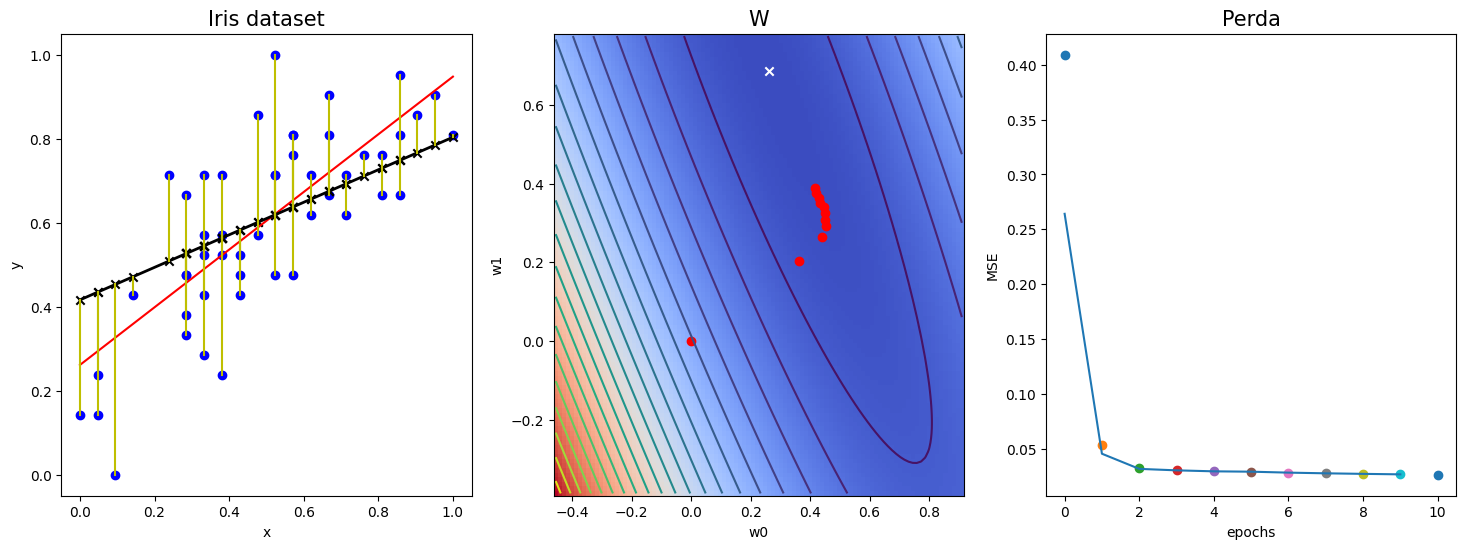

In [10]:
%matplotlib inline
try:
    show_plots(x, y, lr=0.2, n_epochs=10, n_batch=25, sleep=0.1)
except KeyboardInterrupt:
    pass

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoLinear_Otimizacao.png)

## Gradiente Descendente Estocástico

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/MinibatchSGD.png)

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/Loss_MSE_SGD.png)

## Conclusões desse experimento

Quais são as principais conclusões que podemos tirar deste experimento?



# Exercícios

1. Altere os valores de learning rate e épocas para melhorar o modelo.

Ajustar é Fundamental: Mudar as "configurações de treino" (como a velocidade de aprendizado e por quanto tempo treinar) faz uma grande diferença para o computador aprender certo. Se errar nisso, ele não aprende bem.
Treino Leva Tempo (e Velocidade Certa): O computador aprende aos poucos. Precisa de "tempo" suficiente (mais épocas de treino) e da "velocidade" certa para achar a melhor linha que se encaixa nos dados e cometer menos erros.
Gráficos Mostram o Caminho: Olhar os desenhos (gráficos) ajuda a ver se o computador está aprendendo direitinho, se está errando menos e se a linha que ele achou é boa.
Preparar os Dados Ajuda: Deixar os números dos dados mais "organizados" (normalização) antes de treinar facilita o aprendizado do computador.

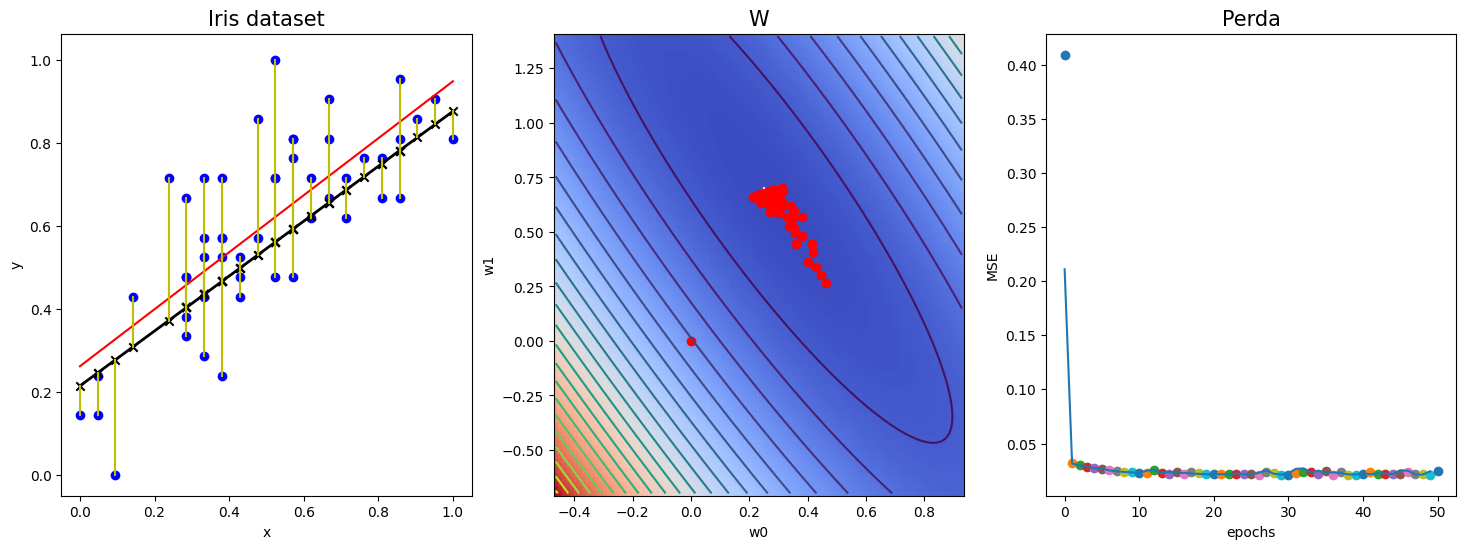

In [11]:
try:
    show_plots(x, y, lr=0.5, n_epochs=50, n_batch=25, sleep=0.1)
except KeyboardInterrupt:
    pass